# MS3 - APCOMP209B

**Data Analysis**: on H/E images - Identify patterns, trends, and outliers in the data. Additionally, explore the relationships between variables and identify any potential confounding variables that may impact the analysis.

**Meaningful on H/E images - Insights**: Based on your analysis of the data, provide meaningful insights, i.e. that connect back to your problem and are relvant to your specific context. Any insights should be well-suported by the data, provide actionable recommendations and have a brief justification for why or how its important to the project

Make sure to include clean and labeled visualizations

## Installs

In [ ]:
%pip install numpy pandas torch scipy openslide-python pydantic pytorch-lightning dask distributed matplotlib seaborn scikit-learn opencv-python scanpy spatialdata zarr ome-zarr

In [ ]:
!pip install spatialdata scanpy

## Imports

In [16]:
# Import libraries
# Core Python Libraries
import os
import json
import warnings
import gc
import joblib
from types import SimpleNamespace
from operator import itemgetter
from abc import abstractmethod
from tqdm import tqdm
import glob
import zipfile

# Core Data manipulation Libraries
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, ConstantInputWarning

# Visualization Library
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

# Spatial Data Processing
import spatialdata as sd  # Manage multi-modal spatial omics datasets
import anndata as ad  # Manage annotated data matrices in memory and on disk
import scanpy as sc  # For analyzing single-cell data, especially for dimensionality reduction and clustering.
from skimage.measure import regionprops  # Get region properties of nucleus/cell image from masked nucleus image
import h5py  # For handling HDF5 data files

# Frameworks for ML and DL models
# import torch
# import timm  # timm: A library to load pretrained SOTA computer vision models (e.g. classification, feature extraction, ...)
# from sklearn.linear_model import Ridge  # Regression model

# Additional packages
import dask.array as da
import xarray as xr
from spatial_image import SpatialImage

In [2]:
from google.colab import drive
drive.mount('/content/drive')

def output_divider():
  print('----------------------------------------')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading H/E images

Let's re-load the image data:

In [17]:
path_to_project = "/content/drive/MyDrive/209B"
path_to_data = "UC6_I.zarr/UC6_I.zarr"
# path_to_data = "DC1.zarr/DC1.zarr"
sdata = sd.read_zarr(os.path.join(path_to_project, path_to_data))

In [74]:
sdata

SpatialData object, with associated Zarr store: /content/drive/.shortcut-targets-by-id/1gGIHAbOd2Iz7voASC_n_CSdgasqWWIaI/209B/UC6_I.zarr/UC6_I.zarr
├── Images
│     ├── 'HE_nuc_original': DataArray[cyx] (1, 20000, 20992)
│     └── 'HE_original': DataArray[cyx] (3, 20000, 20992)
└── Tables
      ├── 'anucleus': AnnData (223790, 460)
      └── 'cell_id-group': AnnData (308924, 0)
with coordinate systems:
    ▸ 'global', with elements:
        HE_nuc_original (Images), HE_original (Images)

Clearly this step is taking a lot of time. We need a way to extract the data in a convenient format once and for all and not have to go through the trouble of reloading everything everytime.

First, we need to break our whole slice image data into pieces: an array of size $20000 \times 20992 \times 3$ is too heavy to be stored or handled in a ML pipeline.
This **patchification** process allows us to generate for every whole slice image a dataset containing a multiple patches. Of course, some (or perhaps many) of these patches do not contain any cells, so we will check to what extent this is the case.

Second, we want to save in the same format, the patches corresponding to cell nuclei segmentation.

Third, we'll save a .npy file of the whole slice image, which can be loaded out of RAM (with less computations).

Fourth, we'll save as dataframes the table reporting gene expression profiles in every cell of the image and the table storing the train/test repartition of cell ids across the image.

Here is a proposal organization of the Preprocessed_data folder:

Preprocessed_data   
├── UC6_I folder  
│$\;\;\;\;\;\;$    ├── HD5 file with HE image patches  
│$\;\;\;\;\;\;$    ├── HD5 file with HE nuclei mask patches   
│$\;\;\;\;\;\;$    ├── Whole Slice image in .npy   
│$\;\;\;\;\;\;$    ├── Gene expression profile  
│$\;\;\;\;\;\;$    └── Group repartition  
├── DC1 folder  
│$\;\;\;\;\;\;$    ├── HD5 file with HE image patches  
│$\;\;\;\;\;\;$    ├── HD5 file with HE nuclei mask patches   
│$\;\;\;\;\;\;$    ├── Whole Slice image in .npy   
│$\;\;\;\;\;\;$    ├── Gene expression profile  
│$\;\;\;\;\;\;$    └── Group repartition  
 etc.

 Due to the computational toll of this process, we will implement this process in this notebook for only the whole slice image "UC6_I", but we'll perform the same preprocessing steps for the other slices we have.

In [77]:
path_to_preprocessed_data = "/content/drive/MyDrive/209B/preprocessed_data"
path_to_uc6_i = "/UC6_I"

In [75]:
gene_expression_data = sdata.tables["anucleus"].to_df()
gene_expression_data.to_csv(path_to_preprocessed_data + path_to_uc6_i + "/gene_expression_data.csv")

In [76]:
group_repartition = sdata.tables["cell_id-group"].obs
group_repartition.to_csv(path_to_preprocessed_data + path_to_uc6_i + "/group_repartition.csv")

## Patchification

Let's store the image in a np array.

In [19]:
he_img_arr = sdata.images['HE_original'].to_numpy()
he_img_arr_t = he_img_arr.transpose(1, 2, 0)

In [78]:
np.save(path_to_preprocessed_data + path_to_uc6_i + "/HE_original.npy", he_img_arr_t)

In [20]:
u,v,_= he_img_arr_t.shape
u/32,v/32

(625.0, 656.0)

The image width and length are divisible by 32. This means we can create $32 \times 32 = 1024$ patches in a dataset.

In [21]:
def patchify_he_img(he_img_arr_t, n_patches = 32):
    patches = {}
    stride_i = he_img_arr_t.shape[0] // n_patches
    stride_j = he_img_arr_t.shape[1] // n_patches
    for i in range(0, he_img_arr_t.shape[0], stride_i):
        for j in range(0, he_img_arr_t.shape[1], stride_j):
            patch = he_img_arr_t[i:i+stride_i, j:j+stride_j, :]
            patches[(i, j)] = patch
    return patches

In [22]:
patches = patchify_he_img(he_img_arr_t) #to patchify the whole slice image

In [23]:
segm_mask_arr = sdata.images["HE_nuc_original"].to_numpy()
segm_mask_arr_t = segm_mask_arr.transpose(1, 2, 0)

In [24]:
segm_patches = patchify_he_img(segm_mask_arr_t) #to patchify the segmentation mask image

Then, let's explore how many **distinct** cells we find in each patch with respect to the cell nuclei segmentation mask.

In [25]:
cell_nb_in_patches = {}
for key, patch in segm_patches.items():
    cell_nb = len(np.unique(patch))
    cell_nb_in_patches[key] = cell_nb

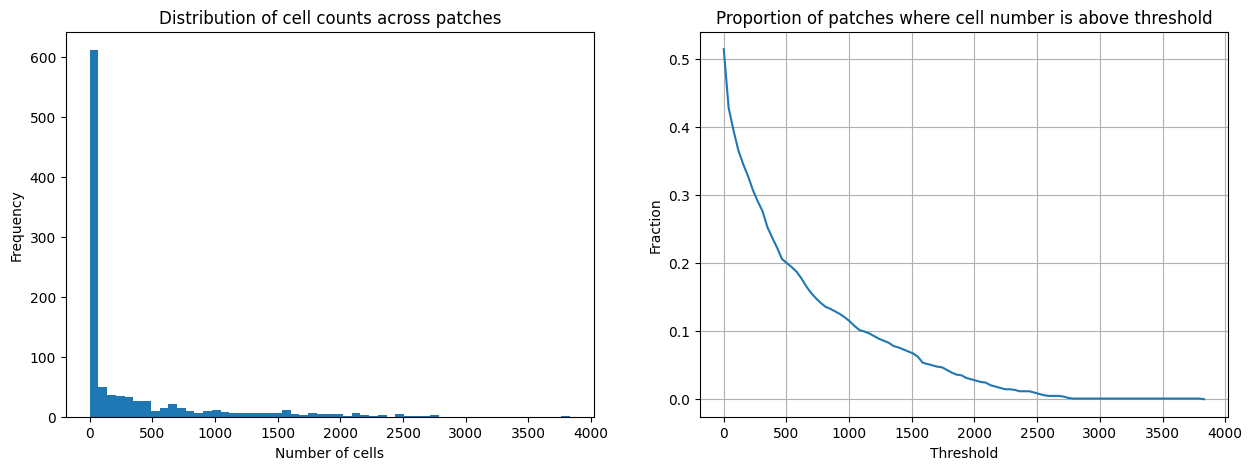

In [26]:
fig, ax = plt.subplots(1,2,figsize=(15, 5))
cell_nb_in_patches_list = list(cell_nb_in_patches.values())
ax[0].hist(cell_nb_in_patches_list, bins="auto")
ax[0].set_title('Distribution of cell counts across patches')
ax[0].set_xlabel('Number of cells')
ax[0].set_ylabel('Frequency')
thr = np.linspace(np.min(cell_nb_in_patches_list), np.max(cell_nb_in_patches_list), 100)
fraction_list = []
for t in thr:
    fraction_list.append(np.sum(np.array(cell_nb_in_patches_list) > t) / len(cell_nb_in_patches_list))
ax[1].plot(thr, fraction_list)
ax[1].set_xlabel('Threshold')
ax[1].set_ylabel('Fraction')
ax[1].set_title('Proportion of patches where cell number is above threshold')
ax[1].grid()
plt.show()

This step is very informative! Approximately 50% of the patches do not contain any cell! It would be totally useless to store all the patches in the image! Next, let us take a look at different levels of cell population across patches.

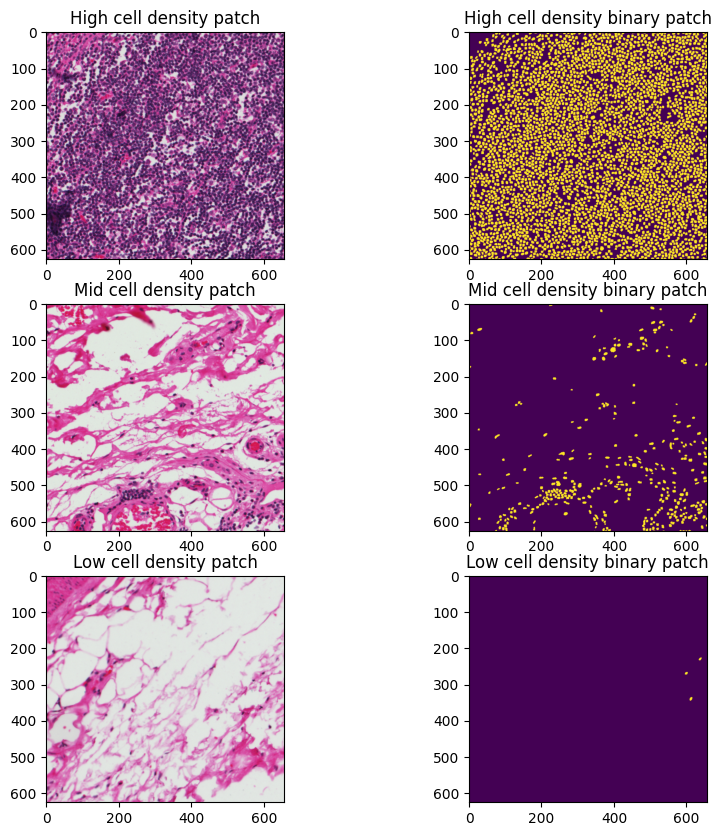

In [27]:
cell_nb_idx_sorted = np.argsort(list(cell_nb_in_patches.values()))
high_cell_density = list(cell_nb_in_patches.keys())[cell_nb_idx_sorted[-1]]
low_cell_density = list(cell_nb_in_patches.keys())[cell_nb_idx_sorted[len(cell_nb_in_patches)//2]]
mid_cell_density = list(cell_nb_in_patches.keys())[cell_nb_idx_sorted[3*len(cell_nb_in_patches)//4]]

fig, ax = plt.subplots(3,2,figsize=(10, 10))
ax[0,0].imshow(patches[high_cell_density])
ax[0,0].set_title('High cell density patch')
ax[0,1].imshow(segm_patches[high_cell_density]>0)
ax[0,1].set_title('High cell density binary patch')

ax[1,0].imshow(patches[mid_cell_density])
ax[1,0].set_title('Mid cell density patch')
ax[1,1].imshow(segm_patches[mid_cell_density]>0)
ax[1,1].set_title('Mid cell density binary patch')

ax[2,0].imshow(patches[low_cell_density])
ax[2,0].set_title('Low cell density patch')
ax[2,1].imshow(segm_patches[low_cell_density]>0)
ax[2,1].set_title('Low cell density binary patch')
plt.show()

In [28]:
non_empty_patches = {}
non_empty_segm_patches = {}
for key, patch in segm_patches.items():
    if np.sum(patch) > 0:
        non_empty_patches[key] = patches[key]
        non_empty_segm_patches[key] = patch
print(f"Number of non-empty patches: {len(non_empty_patches)}")

Number of non-empty patches: 527


Next, we save the patches in HD5 datasets.

In [29]:
def save_patches_to_hd5(patches, filename,path_size):
    with h5py.File(filename, 'w') as f:
        f.attrs['path_size'] = path_size
        for key, patch in tqdm(patches.items()):
            f.create_dataset(f'{key[0]}_{key[1]}', data=patch)
        print(f"Patches saved to {filename}")

In [33]:
save_patches_to_hd5(non_empty_patches, path_to_preprocessed_data + path_to_uc6_i + "/UC6_I_patches.h5",(625,656))
print("HE Image patches dataset saved")
save_patches_to_hd5(non_empty_segm_patches, path_to_preprocessed_data + path_to_uc6_i + "/UC6_I_segm_patches.h5",(625,656))
print("HE Image segmentation patches dataset saved")

100%|██████████| 527/527 [00:14<00:00, 36.10it/s]


Patches saved to /content/drive/MyDrive/209B/preprocessed_data/UC6_I/UC6_I_patches.h5
HE Image patches dataset saved


100%|██████████| 527/527 [00:32<00:00, 16.06it/s]

Patches saved to /content/drive/MyDrive/209B/preprocessed_data/UC6_I/UC6_I_segm_patches.h5
HE Image segmentation patches dataset saved


At this point, we don't need to manipulate this heavy data anymore!

## Analysis of spatial data

In [36]:
he_patches_dataset = h5py.File(path_to_preprocessed_data + path_to_uc6_i + "/UC6_I_patches.h5", 'r')
he_segm_patches_dataset = h5py.File(path_to_preprocessed_data + path_to_uc6_i + "/UC6_I_segm_patches.h5", 'r')

In [80]:
he_array_saved = np.load(path_to_preprocessed_data + path_to_uc6_i + '/HE_original.npy', mmap_mode='r')

First, let us take a look at the patchification output. Which patches did we keep after discarding the empty patches?

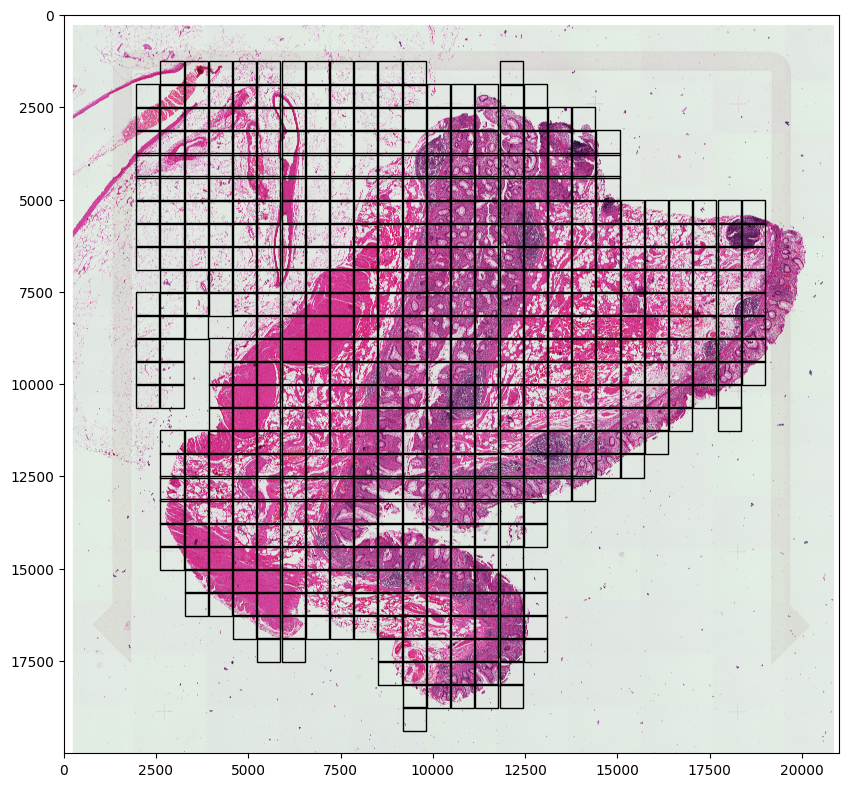

In [82]:
patches_coords = list(he_patches_dataset.keys())
u,v = 625,656

plt.figure(figsize=(10, 10))
plt.imshow(he_array_saved)
for patch_coord in patches_coords:
    coord = tuple(map(int, patch_coord.split('_')))
    #draw a black square with size (u,v)
    plt.gca().add_patch(Rectangle((coord[1], coord[0]), u, v, fill=False, edgecolor='black', linewidth=1))

plt.show()

The output of the patchification step makes sense and overall overlaps with the tissue layout on the whole slice image. Next, we could wonder, how uniformly distributed the cells are across patches.

In [37]:
counts = {coord: len(np.unique(he_segm_patches_dataset[coord])) for coord in he_patches_dataset.keys()}
counts_values = list(counts.values())

In [38]:
img_length_shorter,img_width_shorter = 20000//625,20992//656
temp = np.zeros((img_length_shorter,img_width_shorter))
for coord in he_patches_dataset.keys():
    count = counts[coord]
    coord = tuple(map(int, coord.split('_')))
    temp[coord[0]//625,coord[1]//656] = count

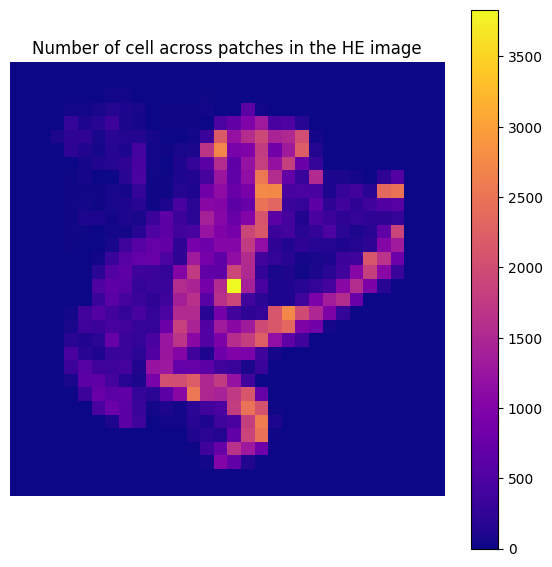

In [39]:
plt.figure(figsize=(7, 7))
plt.imshow(temp,cmap = "plasma")
plt.axis('off')
plt.colorbar()
plt.title("Number of cell across patches in the HE image")
plt.show()

The number of cells across the patches in the H/E stained image vary a lot from one patch to the other. If we want to batch our patches before feeding them into some model, we may want to stratify batches with respect to cell counts. Moreover, these variations follow specific patterns (neighboring patches tend to have more cells), which may be worth tracking through some sort of positional encoding.